<a href="https://colab.research.google.com/github/Agourrame/API_TODO/blob/main/Drought_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, SimpleRNN,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam,RMSprop
import keras_tuner as kt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [6]:
df = pd.read_csv('/content/raw_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

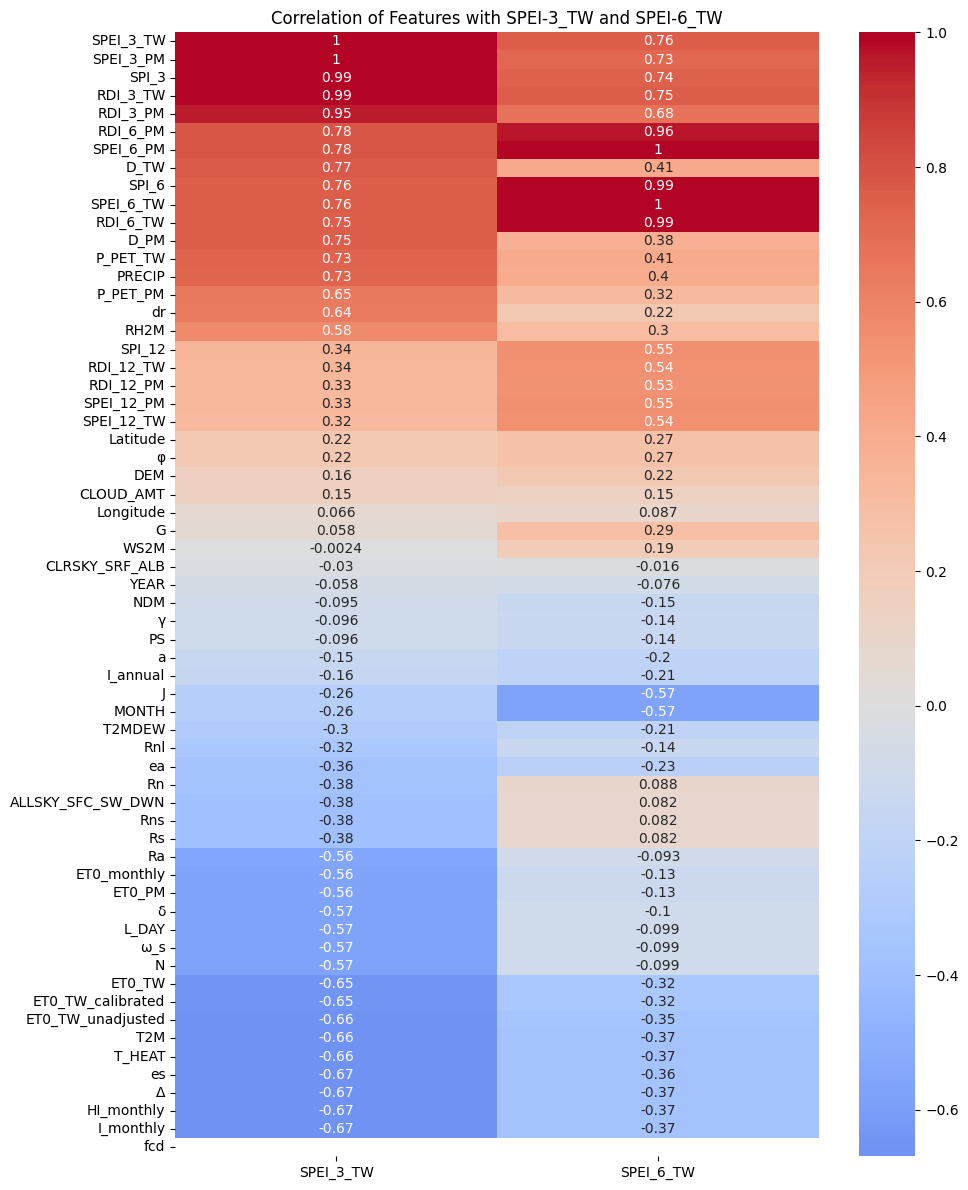

,SPEI_3_TW,SPEI_6_TW
SPEI_3_TW,1.000000,0.756045
SPEI_3_PM,0.997145,0.725562
SPI_3,0.991248,0.743121
RDI_3_TW,0.989002,0.753907
RDI_3_PM,0.954461,0.675434
...,...,...
es,-0.665211,-0.364330
Δ,-0.666835,-0.365910
HI_monthly,-0.669101,-0.368690
I_monthly,-0.669101,-0.368690


In [7]:
# Select only numeric columns including targets
target_cols = ['SPEI_3_TW', 'SPEI_6_TW']
numeric_df = df.select_dtypes(include='number')
correlation_df = numeric_df.corr()

# Extract correlations with target variables
correlation_with_targets = correlation_df[target_cols].sort_values(by=target_cols, ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_with_targets, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Features with SPEI-3_TW and SPEI-6_TW")
plt.tight_layout()
plt.show()

# Print correlation values for reference
correlation_with_targets

In [8]:
#Selected features based on correlation analysis
selected_features = ["PRECIP", "T2M", "T2MDEW", "RH2M", "WS2M", "ET0_PM",
            "ET0_TW_calibrated", "SPI_6", "SPI_12",
            "SPEI_12_TW", "DEM", "MONTH"]

#Target columns
target_cols = ["SPEI_3_TW", "SPEI_6_TW"]

#Load dataset
df = pd.read_csv('/content/raw_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

#Keep only necessary columns
columns_to_keep = ['Date', 'Latitude', 'Longitude'] + selected_features + target_cols
df = df[columns_to_keep].dropna(subset=['Latitude', 'Longitude'])

#Build full spatiotemporal grid
all_dates = df['Date'].drop_duplicates()
all_coords = df[['Latitude', 'Longitude']].drop_duplicates()
full_grid = all_dates.to_frame().merge(all_coords, how='cross')

#Merge original data into full grid
df_full = full_grid.merge(df, on=['Date', 'Latitude', 'Longitude'], how='left')

#Fill missing values using per-location mean for each feature
for col in selected_features + target_cols:
    df_full[col] = df_full.groupby(['Latitude', 'Longitude'])[col].transform(
        lambda x: x.fillna(x.mean())
    )

#Final check — assert no missing values
assert df_full[selected_features + target_cols].isnull().sum().sum() == 0, "❌ Still missing values!"

#Save preprocessed dataset
df_full.to_csv('/content/cleaned_drought_dataset.csv', index=False)
print("Cleaned dataset with selected features saved: selected_cleaned_dataset.csv")


Cleaned dataset with selected features saved: selected_cleaned_dataset.csv


In [9]:
df = pd.read_csv('/content/cleaned_drought_dataset.csv')
df.head(70000)

,Date,Latitude,Longitude,PRECIP,T2M,T2MDEW,RH2M,WS2M,ET0_PM,ET0_TW_calibrated,SPI_6,SPI_12,SPEI_12_TW,DEM,MONTH,SPEI_3_TW,SPEI_6_TW
0,1984-01-01,30.224998,-9.625000,13.922525,12.75,3.93,60.28,1.86,6.608812,9.296535,-0.172527,0.046440,0.094771,77.0,1,-0.152827,-0.143353
1,1984-01-01,30.324997,-9.625000,15.186436,13.44,3.90,57.31,2.16,6.744799,9.256276,0.500161,-0.564449,-0.589426,0.0,1,0.599413,0.526750
2,1984-01-01,30.224998,-9.475006,15.306362,12.75,3.93,60.28,1.86,6.608812,9.296535,0.368308,-0.691131,-0.785761,81.0,1,0.658645,0.394287
3,1984-01-01,30.324997,-9.475006,15.841620,13.44,3.90,57.31,2.16,6.744799,9.256276,0.138511,-0.849093,-0.866815,36.0,1,0.362538,0.207079
4,1984-01-01,30.424995,-9.475006,14.432917,13.44,3.90,57.31,2.16,6.744799,9.255075,0.381134,-0.685474,-0.779890,202.0,1,0.386253,0.406011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62356,2024-12-01,30.625000,-7.975006,33.313670,18.94,0.60,35.87,2.42,11.178950,11.824995,0.167280,-0.058494,-0.103993,1664.0,12,0.475032,0.146843
62357,2024-12-01,30.724998,-7.975006,42.337440,10.25,-2.64,44.86,1.80,8.782095,8.754002,0.083264,0.582343,0.544393,923.0,12,0.629642,-0.037094
62358,2024-12-01,30.724998,-7.975006,42.337440,18.94,0.60,35.87,2.42,11.178950,11.821926,0.509494,0.749463,0.683206,923.0,12,0.775545,0.449309
62359,2024-12-01,30.824997,-7.975006,35.394966,9.39,-2.69,48.21,1.46,8.647819,8.815175,-0.222987,0.563483,0.596623,2193.0,12,0.371805,-0.259658


In [10]:
# Load the cleaned dataset
file_path = '/content/cleaned_drought_dataset.csv'
df = pd.read_csv(file_path)

# Show basic info
print("Dataset Info:")
df.info()

# Show a sample
print("\n Sample Rows:")
print(df.head())

# Check for missing values
print("\n Missing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62361 entries, 0 to 62360
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               62361 non-null  object 
 1   Latitude           62361 non-null  float64
 2   Longitude          62361 non-null  float64
 3   PRECIP             62361 non-null  float64
 4   T2M                62361 non-null  float64
 5   T2MDEW             62361 non-null  float64
 6   RH2M               62361 non-null  float64
 7   WS2M               62361 non-null  float64
 8   ET0_PM             62361 non-null  float64
 9   ET0_TW_calibrated  62361 non-null  float64
 10  SPI_6              62361 non-null  float64
 11  SPI_12             62361 non-null  float64
 12  SPEI_12_TW         62361 non-null  float64
 13  DEM                62361 non-null  float64
 14  MONTH              62361 non-null  int64  
 15  SPEI_3_TW          62361 non-null  float64
 16  SPEI_6_T

In [11]:
# Load your dataset
df = pd.read_csv("/content/cleaned_drought_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Define features and target
features = ["PRECIP", "T2M", "T2MDEW", "RH2M", "WS2M", "ET0_PM",
            "ET0_TW_calibrated", "SPI_6", "SPI_12", "SPEI_6_TW",
            "SPEI_12_TW", "DEM", "MONTH"]
target = "SPEI_3_TW"

# Filter for training period only (1984–2024, forecasting 2025)
df = df[df["Date"].dt.year <= 2024]

In [12]:
X_all, y_all, dates_all = [], [], []

for (lat, lon), group in df.groupby(["Latitude", "Longitude"]):
    group = group.sort_values("Date")

    # Ensure at least 24 months (12 for input, 12 for output)
    for i in range(len(group) - 24 + 1):
        window = group.iloc[i:i+24]
        X_seq = window.iloc[:12][features].values
        y_seq = window.iloc[12:][target].values

        if len(X_seq) == 12 and len(y_seq) == 12:
            X_all.append(X_seq)
            y_all.append(y_seq)
            dates_all.append(window.iloc[11]["Date"])  # midpoint (last date of input)


In [13]:
# Temporal split
X_train = X_all[dates_all.year <= 2020]
y_train = y_all[dates_all.year <= 2020]

X_val = X_all[(dates_all.year > 2020) & (dates_all.year <= 2022)]
y_val = y_all[(dates_all.year > 2020) & (dates_all.year <= 2022)]

X_test = X_all[(dates_all.year > 2022) & (dates_all.year <= 2024)]
y_test = y_all[(dates_all.year > 2022) & (dates_all.year <= 2024)]



AttributeError: 'list' object has no attribute 'year'

In [27]:
# Flatten all sequences for scaler fitting
scaler_X = MinMaxScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler_X.fit(X_train_flat)

# Apply to all
X_train = scaler_X.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val   = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


In [ ]:
model = Sequential([
    Input(shape=(12, len(features))),
    LSTM(64, return_sequences=False),
    Dense(12)  # Predict next 12 months
])

model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.4521 - val_loss: 0.1778
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.2433 - val_loss: 0.1726
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2142 - val_loss: 0.1635
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1974 - val_loss: 0.1614
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1839 - val_loss: 0.1793
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1721 - val_loss: 0.2191
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1639 - val_loss: 0.2143
Epoch 8/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.1564 - val_loss: 0.2384
Epoch 9/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.1497 - val_loss: 0.2707
Epoch 10/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1420 - val_loss: 0.2608
Epoch 11/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1358 - val_loss: 0.2548
Epoch 12/100
860/860 ━

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

# Initialize lists to collect metrics
mae_list, rmse_list, r2_list = [], [], []

# Evaluate per forecast month (T+1 to T+12)
for t in range(12):
    mae = mean_absolute_error(y_test[:, t], y_pred[:, t])
    rmse = np.sqrt(mean_squared_error(y_test[:, t], y_pred[:, t]))
    r2 = r2_score(y_test[:, t], y_pred[:, t])

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"T+{t+1} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

# Print mean scores
print("\nMean Summary Evaluation")
print(f"Mean MAE:  {np.mean(mae_list):.4f}")
print(f"Mean RMSE: {np.mean(rmse_list):.4f}")
print(f"Mean R²:   {np.mean(r2_list):.4f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
T+1 | MAE: 0.1704 | RMSE: 0.2241 | R²: 0.9083
T+2 | MAE: 0.2166 | RMSE: 0.2965 | R²: 0.8352
T+3 | MAE: 0.2802 | RMSE: 0.3702 | R²: 0.7214
T+4 | MAE: 0.2931 | RMSE: 0.3820 | R²: 0.6670
T+5 | MAE: 0.2270 | RMSE: 0.3094 | R²: 0.7817
T+6 | MAE: 0.2198 | RMSE: 0.2905 | R²: 0.8160
T+7 | MAE: 0.2021 | RMSE: 0.2642 | R²: 0.8552
T+8 | MAE: 0.1921 | RMSE: 0.2475 | R²: 0.8696
T+9 | MAE: 0.1733 | RMSE: 0.2198 | R²: 0.8885
T+10 | MAE: 0.1526 | RMSE: 0.1977 | R²: 0.9086
T+11 | MAE: 0.2291 | RMSE: 0.2947 | R²: 0.8018
T+12 | MAE: 0.2662 | RMSE: 0.3522 | R²: 0.7240

📌 Mean Summary Evaluation
Mean MAE:  0.2185
Mean RMSE: 0.2874
Mean R²:   0.8148


In [ ]:
gru_model = Sequential([
    GRU(64, input_shape=(12, 13), return_sequences=False),
    Dropout(0.2),
    Dense(12)
])

gru_model.compile(optimizer=Adam(1e-3), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.4896 - val_loss: 0.1803
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2578 - val_loss: 0.1585
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2296 - val_loss: 0.1746
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2128 - val_loss: 0.1833
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1983 - val_loss: 0.1708
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1883 - val_loss: 0.2474
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1792 - val_loss: 0.2080


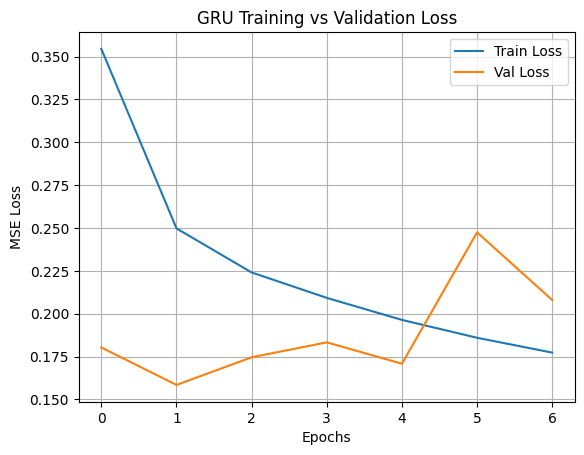

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("GRU Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = gru_model.predict(X_test)

for t in range(12):
    print(f"T+{t+1} | MAE: {mean_absolute_error(y_test[:, t], y_pred[:, t]):.4f} | "
          f"RMSE: {mean_squared_error(y_test[:, t], y_pred[:, t]) ** 0.5:.4f} | "
          f"R²: {r2_score(y_test[:, t], y_pred[:, t]):.4f}")

# Mean summary
mae_mean = np.mean([mean_absolute_error(y_test[:, t], y_pred[:, t]) for t in range(12)])
rmse_mean = np.mean([mean_squared_error(y_test[:, t], y_pred[:, t]) ** 0.5 for t in range(12)])
r2_mean = np.mean([r2_score(y_test[:, t], y_pred[:, t]) for t in range(12)])

print("\n Mean MAE:", round(mae_mean, 4))
print("Mean RMSE:", round(rmse_mean, 4))
print("Mean R²:", round(r2_mean, 4))



52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
T+1 | MAE: 0.1885 | RMSE: 0.2577 | R²: 0.8787
T+2 | MAE: 0.2384 | RMSE: 0.3243 | R²: 0.8029
T+3 | MAE: 0.3067 | RMSE: 0.3969 | R²: 0.6798
T+4 | MAE: 0.2935 | RMSE: 0.3752 | R²: 0.6787
T+5 | MAE: 0.2384 | RMSE: 0.3132 | R²: 0.7764
T+6 | MAE: 0.2410 | RMSE: 0.3241 | R²: 0.7709
T+7 | MAE: 0.2551 | RMSE: 0.3458 | R²: 0.7520
T+8 | MAE: 0.2584 | RMSE: 0.3455 | R²: 0.7458
T+9 | MAE: 0.2440 | RMSE: 0.3117 | R²: 0.7758
T+10 | MAE: 0.2450 | RMSE: 0.3000 | R²: 0.7895
T+11 | MAE: 0.2989 | RMSE: 0.3496 | R²: 0.7211
T+12 | MAE: 0.3268 | RMSE: 0.3853 | R²: 0.6697

📌 Mean MAE: 0.2612
📌 Mean RMSE: 0.3358
📌 Mean R²: 0.7534


In [ ]:
# 1. Define the model
rnn_model = Sequential([
    Input(shape=(12, X_train.shape[2])),  # 12 time steps, n features
    SimpleRNN(64, activation='tanh'),
    Dense(12)  # Forecast 12 months ahead
])

# 2. Compile
rnn_model.compile(optimizer='adam', loss='mse')

# 3. Train with EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.3405 - val_loss: 0.1671
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2110 - val_loss: 0.2001
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1912 - val_loss: 0.2704
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1749 - val_loss: 0.2418
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1634 - val_loss: 0.3290
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1470 - val_loss: 0.2827
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1381 - val_loss: 0.2662
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1253 - val_loss: 0.2823
Epoch 9/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1174 - val_loss: 0.2888
Epoch 10/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1105 - val_loss: 0.2755
Epoch 11/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1044 - val_loss: 0.2838


In [ ]:
# Evaluate on Test Set (2023–2024)
y_pred = rnn_model.predict(X_test)

for t in range(12):
    print(f"T+{t+1} | MAE: {mean_absolute_error(y_test[:, t], y_pred[:, t]):.4f} | "
          f"RMSE: {mean_squared_error(y_test[:, t], y_pred[:, t]) ** 0.5:.4f} | "
          f"R²: {r2_score(y_test[:, t], y_pred[:, t]):.4f}")

# Mean summary
mae_mean = np.mean([mean_absolute_error(y_test[:, t], y_pred[:, t]) for t in range(12)])
rmse_mean = np.mean([mean_squared_error(y_test[:, t], y_pred[:, t]) ** 0.5 for t in range(12)])
r2_mean = np.mean([r2_score(y_test[:, t], y_pred[:, t]) for t in range(12)])

print("\n📌 Mean MAE:", round(mae_mean, 4))
print("📌 Mean RMSE:", round(rmse_mean, 4))
print("📌 Mean R²:", round(r2_mean, 4))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
T+1 | MAE: 0.1472 | RMSE: 0.2025 | R²: 0.9251
T+2 | MAE: 0.1983 | RMSE: 0.2710 | R²: 0.8624
T+3 | MAE: 0.2476 | RMSE: 0.3339 | R²: 0.7734
T+4 | MAE: 0.2829 | RMSE: 0.3703 | R²: 0.6871
T+5 | MAE: 0.2206 | RMSE: 0.2854 | R²: 0.8143
T+6 | MAE: 0.2068 | RMSE: 0.2579 | R²: 0.8550
T+7 | MAE: 0.1996 | RMSE: 0.2434 | R²: 0.8771
T+8 | MAE: 0.2009 | RMSE: 0.2473 | R²: 0.8698
T+9 | MAE: 0.2043 | RMSE: 0.2638 | R²: 0.8394
T+10 | MAE: 0.2794 | RMSE: 0.3410 | R²: 0.7279
T+11 | MAE: 0.3414 | RMSE: 0.4158 | R²: 0.6055
T+12 | MAE: 0.3414 | RMSE: 0.4276 | R²: 0.5933

📌 Mean MAE: 0.2392
📌 Mean RMSE: 0.305
📌 Mean R²: 0.7859


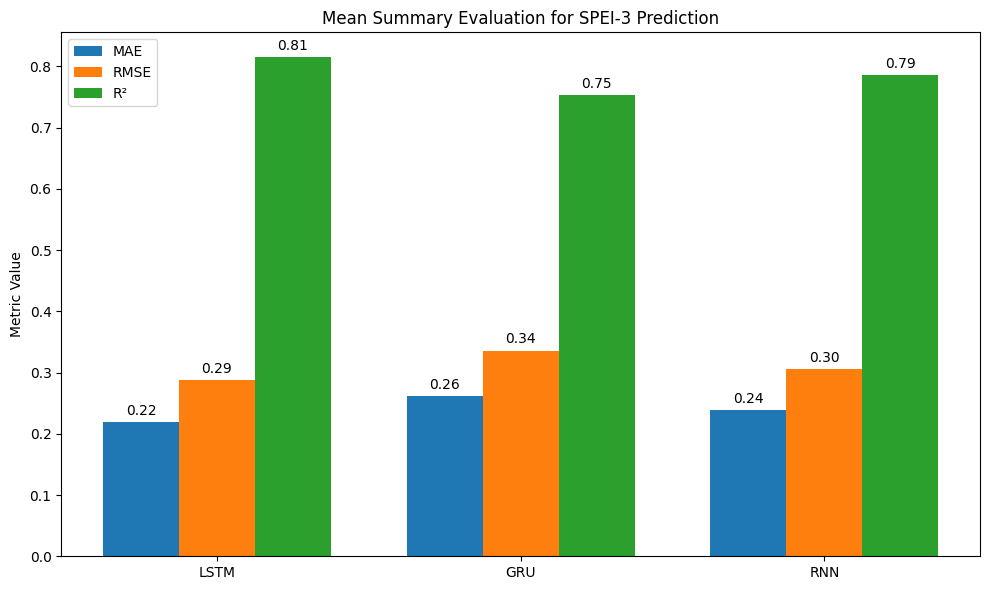

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LSTM', 'GRU', 'RNN']

# Metrics
mae = [0.2185, 0.2612, 0.2392]
rmse = [0.2874, 0.3358, 0.305]
r2 = [0.8148, 0.7534, 0.7859]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, mae, width, label='MAE')
bars2 = ax.bar(x, rmse, width, label='RMSE')
bars3 = ax.bar(x + width, r2, width, label='R²')

# Labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Mean Summary Evaluation for SPEI-3 Prediction')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [28]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(12, X_train.shape[2])))

    # Add 1 or 2 LSTM layers
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=(i != hp.get('num_layers') - 1)))
        model.add(Dropout(rate=hp.Choice("dropout", [0.1, 0.2, 0.3])))

    model.add(Dense(12))  # 12-month prediction

    # Optimizer
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling='log'))
    else:
        optimizer = RMSprop(learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling='log'))

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


In [32]:
tuner = kt.Hyperband(
    build_lstm_model,
    objective="val_loss",
    max_epochs=30,
    factor=3,
    directory="tuner_results",
    project_name="lstm_spei3_temporal"
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_val, y_val),
             callbacks=[early_stop],
             verbose=1)


Trial 74 Complete [00h 07m 24s]
val_loss: 0.16084636747837067

Best val_loss So Far: 0.14455588161945343
Total elapsed time: 03h 12m 20s


In [33]:
# Get best model
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for hp in best_hps.values:
    print(f"{hp}: {best_hps[hp]}")

# Build the model and retrain
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])


Best hyperparameters:
num_layers: 1
units_0: 96
dropout: 0.1
optimizer: rmsprop
learning_rate: 0.0015498572359259769
units_1: 96
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.3521 - mae: 0.3958 - val_loss: 0.1890 - val_mae: 0.3072
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.2295 - mae: 0.3151 - val_loss: 0.2282 - val_mae: 0.3252
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.1990 - mae: 0.2925 - val_loss: 0.1859 - val_mae: 0.2873
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1710 - mae: 0.2728 - val_loss: 0.2386 - val_mae: 0.3330
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.1528 - mae: 0.2591 - val_loss: 0.2394 - val_mae: 0.3177
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1341 - mae: 0.2458 - val_loss: 0.2303 - val_mae: 0.3092
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.12

In [34]:
y_pred = best_model.predict(X_test)

# Calculate and summarize metrics
maes, rmses, r2s = [], [], []
for t in range(12):
    mae = mean_absolute_error(y_test[:, t], y_pred[:, t])
    rmse = np.sqrt(mean_squared_error(y_test[:, t], y_pred[:, t]))
    r2 = r2_score(y_test[:, t], y_pred[:, t])
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    print(f"T+{t+1} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

print(f"\n Mean MAE: {np.mean(maes):.4f}")
print(f" Mean RMSE: {np.mean(rmses):.4f}")
print(f" Mean R²: {np.mean(r2s):.4f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
T+1 | MAE: 0.1485 | RMSE: 0.2022 | R²: 0.9253
T+2 | MAE: 0.2061 | RMSE: 0.2732 | R²: 0.8600
T+3 | MAE: 0.2453 | RMSE: 0.3304 | R²: 0.7782
T+4 | MAE: 0.2554 | RMSE: 0.3357 | R²: 0.7429
T+5 | MAE: 0.2094 | RMSE: 0.2829 | R²: 0.8176
T+6 | MAE: 0.1907 | RMSE: 0.2577 | R²: 0.8552
T+7 | MAE: 0.1621 | RMSE: 0.2242 | R²: 0.8957
T+8 | MAE: 0.1469 | RMSE: 0.1949 | R²: 0.9191
T+9 | MAE: 0.1591 | RMSE: 0.2058 | R²: 0.9023
T+10 | MAE: 0.1898 | RMSE: 0.2379 | R²: 0.8676
T+11 | MAE: 0.2315 | RMSE: 0.2938 | R²: 0.8031
T+12 | MAE: 0.3008 | RMSE: 0.3940 | R²: 0.6547

 Mean MAE: 0.2038
 Mean RMSE: 0.2694
 Mean R²: 0.8351


In [14]:
# Define features and target
features = ["PRECIP", "T2M", "T2MDEW", "RH2M", "WS2M", "ET0_PM",
            "ET0_TW_calibrated", "SPI_6", "SPI_12", "SPEI_3_TW",
            "SPEI_12_TW", "DEM", "MONTH"]
target_col = "SPEI_6_TW"

# Initialize lists
X, y, dates, coords = [], [], [], []

# Group by (lat, lon)
for (lat, lon), group in df.groupby(["Latitude", "Longitude"]):
    group = group.sort_values("Date")
    if len(group) >= 24:  # Ensure we have enough time steps
        for i in range(len(group) - 12):
            seq_X = group.iloc[i:i+12][features].values
            seq_y = group.iloc[i+12:i+24][target_col].values  # Next 12 months
            if len(seq_y) == 12:
                X.append(seq_X)
                y.append(seq_y)
                dates.append(group.iloc[i+12]["Date"])
                coords.append((lat, lon))

# Convert to arrays
X_all = np.array(X)
y_all = np.array(y)
dates_all = pd.to_datetime(dates)

print(f"X shape: {X_all.shape} | y shape: {y_all.shape} | Unique dates: {dates_all.min()} → {dates_all.max()}")


X shape: (59670, 12, 13) | y shape: (59670, 12) | Unique dates: 1984-12-01 00:00:00 → 2024-02-01 00:00:00


In [16]:
# Temporal split (remove .dt)
X_train = X_all_scaled[dates_all.year <= 2020]
y_train = y_all[dates_all.year <= 2020]

X_val = X_all_scaled[(dates_all.year == 2021) | (dates_all.year == 2022)]
y_val = y_all[(dates_all.year == 2021) | (dates_all.year == 2022)]

X_test = X_all_scaled[dates_all.year >= 2023]
y_test = y_all[dates_all.year >= 2023]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (54873, 12, 13), Val: (3042, 12, 13), Test: (1755, 12, 13)


In [17]:
# 1. Define the LSTM model
lstm_model_6 = Sequential([
    Input(shape=(12, X_train.shape[2])),
    LSTM(64),
    Dense(12)  # Predict next 12 months
])

lstm_model_6.compile(optimizer='adam', loss='mse')

# 2. Train the model with early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = lstm_model_6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.3796 - val_loss: 0.1494
Epoch 2/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2358 - val_loss: 0.1914
Epoch 3/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.2014 - val_loss: 0.3783
Epoch 4/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.1805 - val_loss: 0.3361
Epoch 5/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.1578 - val_loss: 0.4033
Epoch 6/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.1427 - val_loss: 0.4564
Epoch 7/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.1274 - val_loss: 0.4545
Epoch 8/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.1181 - val_loss: 0.3597
Epoch 9/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.1063 - val_loss: 0.3934
Epoch 10/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.1004 - val_loss: 0.4079
Epoch 11/100
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0911 - val_loss: 0.3456


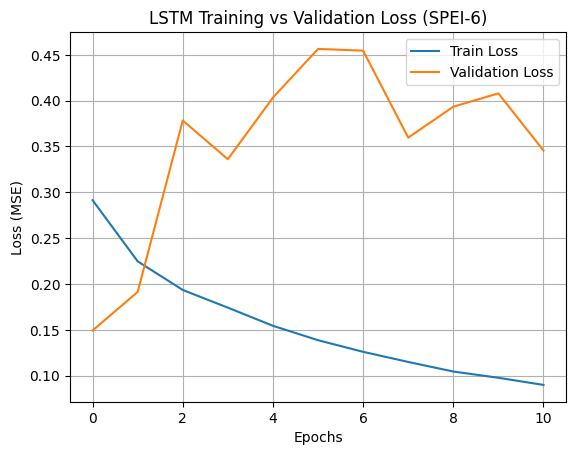

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
T+1 | MAE: 0.2421 | RMSE: 0.3061 | R²: 0.8144
T+2 | MAE: 0.2703 | RMSE: 0.3281 | R²: 0.8051
T+3 | MAE: 0.3285 | RMSE: 0.4080 | R²: 0.6970
T+4 | MAE: 0.3434 | RMSE: 0.4257 | R²: 0.6574
T+5 | MAE: 0.3637 | RMSE: 0.4442 | R²: 0.6046
T+6 | MAE: 0.3703 | RMSE: 0.4475 | R²: 0.5789
T+7 | MAE: 0.3291 | RMSE: 0.4168 | R²: 0.6318
T+8 | MAE: 0.3009 | RMSE: 0.3860 | R²: 0.6984
T+9 | MAE: 0.2654 | RMSE: 0.3456 | R²: 0.7598
T+10 | MAE: 0.2554 | RMSE: 0.3259 | R²: 0.7755
T+11 | MAE: 0.2827 | RMSE: 0.3385 | R²: 0.7455
T+12 | MAE: 0.2920 | RMSE: 0.3496 | R²: 0.7182

Mean MAE: 0.3036
Mean RMSE: 0.3768
Mean R²: 0.7072


In [19]:
# Plot Loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training vs Validation Loss (SPEI-6)")
plt.legend()
plt.grid(True)
plt.show()

# Predict on Test Set
y_pred = lstm_model_6.predict(X_test)

# Compute MAE, RMSE, R² for each forecast horizon (T+1 to T+12)
mae_list, rmse_list, r2_list = [], [], []

for t in range(12):
    y_true_t = y_test[:, t]
    y_pred_t = y_pred[:, t]

    mae = mean_absolute_error(y_true_t, y_pred_t)
    rmse = np.sqrt(mean_squared_error(y_true_t, y_pred_t))  # <- Fixed
    r2 = r2_score(y_true_t, y_pred_t)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"T+{t+1} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")


# Mean summary
print("\nMean MAE:", round(np.mean(mae_list), 4))
print("Mean RMSE:", round(np.mean(rmse_list), 4))
print("Mean R²:", round(np.mean(r2_list), 4))


In [20]:
# Define GRU model for SPEI-6
gru_model_6 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, return_sequences=False),
    Dense(12)  # Predict 12 future months
])

gru_model_6.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru_6 = gru_model_6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.4261 - val_loss: 0.1777
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2384 - val_loss: 0.1675
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.2153 - val_loss: 0.2218
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1947 - val_loss: 0.2665
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1801 - val_loss: 0.3254
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1616 - val_loss: 0.3672
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1501 - val_loss: 0.2782
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1356 - val_loss: 0.4549
Epoch 9/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1265 - val_loss: 0.4819
Epoch 10/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1172 - val_loss: 0.3988
Epoch 11/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1112 - val_loss: 0.5939
Epoch 12/100
858/858

In [23]:
# Predict
y_pred = gru_model_6.predict(X_test)

# Compute metrics for each forecast horizon T+1 to T+12
mae_list, rmse_list, r2_list = [], [], []

for t in range(12):
    y_true_t = y_test[:, t]
    y_pred_t = y_pred[:, t]

    mae = mean_absolute_error(y_true_t, y_pred_t)
    rmse = np.sqrt(mean_squared_error(y_true_t, y_pred_t))  # <- Fixed
    r2 = r2_score(y_true_t, y_pred_t)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"T+{t+1} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

# Mean scores
print("\n Mean MAE:", round(np.mean(mae_list), 4))
print(" Mean RMSE:", round(np.mean(rmse_list), 4))
print(" Mean R²:", round(np.mean(r2_list), 4))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
T+1 | MAE: 0.2098 | RMSE: 0.2790 | R²: 0.8458
T+2 | MAE: 0.2523 | RMSE: 0.3179 | R²: 0.8170
T+3 | MAE: 0.3176 | RMSE: 0.4107 | R²: 0.6930
T+4 | MAE: 0.3231 | RMSE: 0.4290 | R²: 0.6521
T+5 | MAE: 0.3064 | RMSE: 0.4087 | R²: 0.6652
T+6 | MAE: 0.3220 | RMSE: 0.4240 | R²: 0.6219
T+7 | MAE: 0.3303 | RMSE: 0.4324 | R²: 0.6037
T+8 | MAE: 0.2991 | RMSE: 0.3865 | R²: 0.6977
T+9 | MAE: 0.2639 | RMSE: 0.3352 | R²: 0.7740
T+10 | MAE: 0.2567 | RMSE: 0.3202 | R²: 0.7832
T+11 | MAE: 0.2730 | RMSE: 0.3330 | R²: 0.7537
T+12 | MAE: 0.3393 | RMSE: 0.3950 | R²: 0.6403

 Mean MAE: 0.2911
 Mean RMSE: 0.3726
 Mean R²: 0.7123


In [24]:
# Build the RNN model
rnn_model_6 = Sequential([
    Input(shape=(12, X_train.shape[2])),
    SimpleRNN(64, activation='tanh'),
    Dense(12)
])

rnn_model_6.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Train
history_rnn_6 = rnn_model_6.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3850 - val_loss: 0.1650
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2352 - val_loss: 0.2176
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2084 - val_loss: 0.2114
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1893 - val_loss: 0.2859
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1742 - val_loss: 0.2620
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1627 - val_loss: 0.3300
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1519 - val_loss: 0.3442
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1448 - val_loss: 0.3845
Epoch 9/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1344 - val_loss: 0.5048
Epoch 10/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1266 - val_loss: 0.4355
Epoch 11/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1190 - val_loss: 0.5059


In [26]:
# Predict
y_pred = rnn_model_6.predict(X_test)

# Evaluate each horizon (T+1 to T+12)
mae_list, rmse_list, r2_list = [], [], []

for t in range(12):
    y_true_t = y_test[:, t]
    y_pred_t = y_pred[:, t]

    mae = mean_absolute_error(y_true_t, y_pred_t)
    rmse = np.sqrt(mean_squared_error(y_true_t, y_pred_t))
    r2 = r2_score(y_true_t, y_pred_t)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"T+{t+1} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

#  Mean metrics
print("\nMean MAE:", round(np.mean(mae_list), 4))
print("Mean RMSE:", round(np.mean(rmse_list), 4))
print("Mean R²:", round(np.mean(r2_list), 4))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
T+1 | MAE: 0.3176 | RMSE: 0.4312 | R²: 0.6316
T+2 | MAE: 0.3375 | RMSE: 0.4264 | R²: 0.6709
T+3 | MAE: 0.3720 | RMSE: 0.4579 | R²: 0.6184
T+4 | MAE: 0.3460 | RMSE: 0.4212 | R²: 0.6645
T+5 | MAE: 0.2845 | RMSE: 0.3720 | R²: 0.7227
T+6 | MAE: 0.3149 | RMSE: 0.4004 | R²: 0.6629
T+7 | MAE: 0.3086 | RMSE: 0.3914 | R²: 0.6754
T+8 | MAE: 0.3335 | RMSE: 0.4081 | R²: 0.6629
T+9 | MAE: 0.3056 | RMSE: 0.3712 | R²: 0.7228
T+10 | MAE: 0.3059 | RMSE: 0.3636 | R²: 0.7205
T+11 | MAE: 0.3943 | RMSE: 0.4374 | R²: 0.5750
T+12 | MAE: 0.3978 | RMSE: 0.4467 | R²: 0.5399

Mean MAE: 0.3349
Mean RMSE: 0.4106
Mean R²: 0.6556


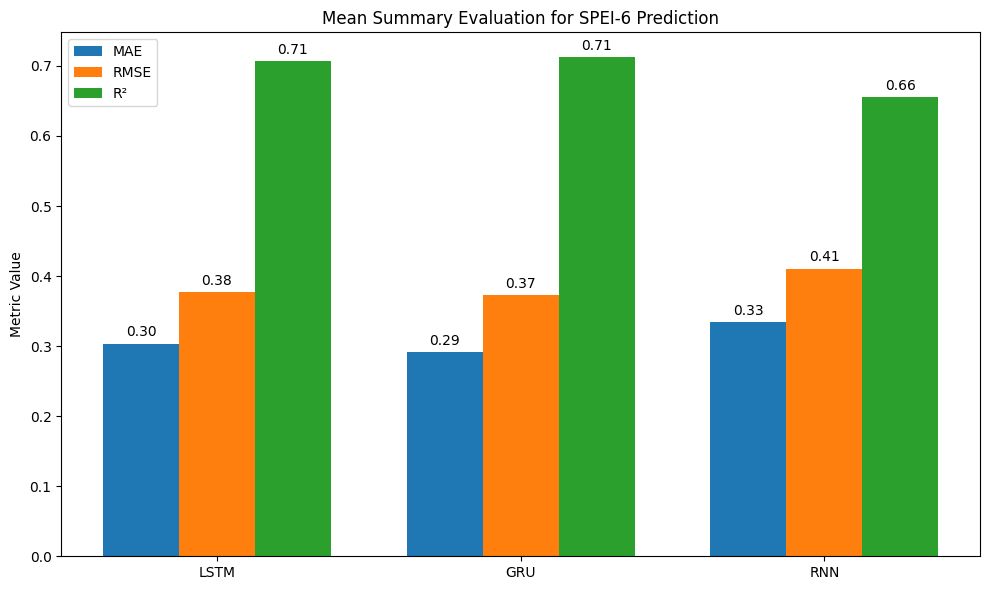

In [28]:
# Metrics for each model (replace with your actual values if different)
models = ['LSTM', 'GRU', 'RNN']

mae_values = [0.3036, 0.2911, 0.3349]
rmse_values = [0.3768, 0.3726, 0.4106]
r2_values = [0.7072, 0.7123, 0.6556]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, mae_values, width, label='MAE')
bars2 = ax.bar(x, rmse_values, width, label='RMSE')
bars3 = ax.bar(x + width, r2_values, width, label='R²')

# Labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Mean Summary Evaluation for SPEI-6 Prediction')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [40]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int("units", min_value=32, max_value=128, step=32),
        activation=hp.Choice("activation", values=["tanh", "relu"]),
        input_shape=(12, 13),
        return_sequences=False
    ))
    model.add(Dense(12))  # Predict 12 months

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError()]
    )
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_gru_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="gru_spei6_tuning",
    project_name="gru_spei6"
)

# Start search (replace X_train, y_train with your variables)
tuner.search(X_train, y_train, epochs=100, batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
             verbose=1)


In [41]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hps.values)


Best hyperparameters: {'units': 128, 'activation': 'relu', 'learning_rate': 0.0001}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# Best hyperparameters from tuning
best_units = 128
best_activation = 'relu'
best_lr = 0.0001

# Build the final GRU model
best_gru_spei6 = Sequential([
    GRU(units=best_units, activation=best_activation, input_shape=(12, 13)),
    Dense(12)  # Forecast 12 months
])

best_gru_spei6.compile(optimizer=Adam(learning_rate=best_lr),
                       loss='mse',
                       metrics=['mae'])

# Train the final model
history = best_gru_spei6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7331 - mae: 0.6291 - val_loss: 0.1655 - val_mae: 0.2962
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.2928 - mae: 0.3788 - val_loss: 0.1727 - val_mae: 0.3125
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.2671 - mae: 0.3604 - val_loss: 0.1694 - val_mae: 0.3066
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.2581 - mae: 0.3532 - val_loss: 0.1711 - val_mae: 0.3050
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.2456 - mae: 0.3435 - val_loss: 0.1581 - val_mae: 0.2884
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.2453 - mae: 0.3422 - val_loss: 0.1638 - val_mae: 0.2961
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.2393 - mae: 0.3382 - val_loss: 0.1668 - val_mae: 0.2973
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 0.2317 - mae: 0.3316 - val_loss: 0.1474 - val_mae: 0.2784
Epoch 9/100
858/858 ━━━━━━━━━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean MAE: 0.2831
Mean RMSE: 0.3525
Mean R²: 0.7456


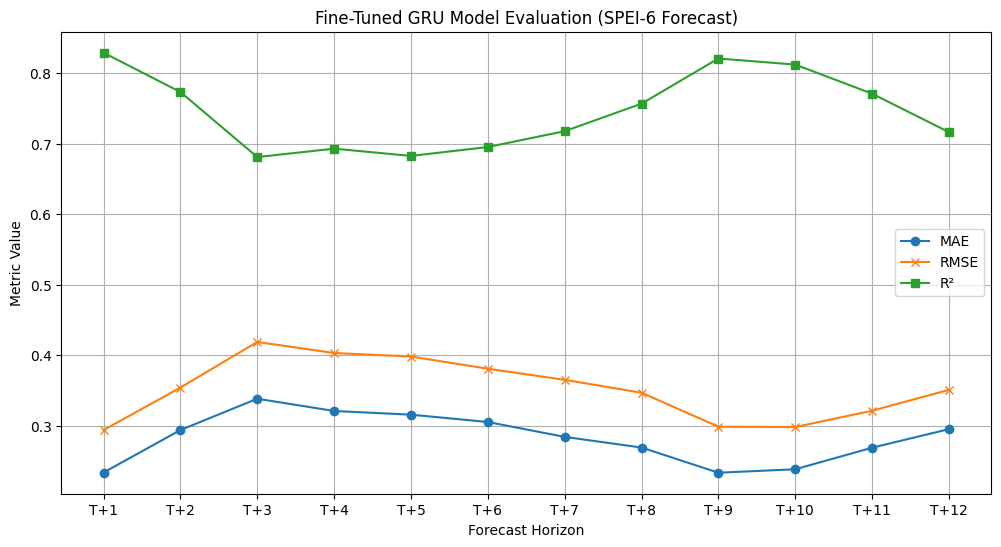

,Month,MAE,RMSE,R²
0,T+1,0.2337,0.2939,0.8288
1,T+2,0.2939,0.3541,0.7731
2,T+3,0.3383,0.4188,0.6809
3,T+4,0.3209,0.4031,0.6928
4,T+5,0.3157,0.3981,0.6825
5,T+6,0.3053,0.3808,0.6951
6,T+7,0.2842,0.3651,0.7176
7,T+8,0.2691,0.3468,0.7566
8,T+9,0.2334,0.2986,0.8206
9,T+10,0.2383,0.2982,0.8120


In [43]:
# Predict on test set
y_pred = best_gru_spei6.predict(X_test)

# Evaluate metrics per forecast month
mae_list, rmse_list, r2_list = [], [], []

for t in range(12):
    y_true_t = y_test[:, t]
    y_pred_t = y_pred[:, t]

    mae = mean_absolute_error(y_true_t, y_pred_t)
    rmse = mean_squared_error(y_true_t, y_pred_t) ** 0.5
    r2 = r2_score(y_true_t, y_pred_t)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Build summary DataFrame
metrics_df = pd.DataFrame({
    "Month": [f"T+{i+1}" for i in range(12)],
    "MAE": mae_list,
    "RMSE": rmse_list,
    "R²": r2_list
}).round(4)

# Print mean metrics
print("Mean MAE:", round(np.mean(mae_list), 4))
print("Mean RMSE:", round(np.mean(rmse_list), 4))
print("Mean R²:", round(np.mean(r2_list), 4))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(metrics_df["Month"], metrics_df["MAE"], marker='o', label="MAE")
plt.plot(metrics_df["Month"], metrics_df["RMSE"], marker='x', label="RMSE")
plt.plot(metrics_df["Month"], metrics_df["R²"], marker='s', label="R²")
plt.title("Fine-Tuned GRU Model Evaluation (SPEI-6 Forecast)")
plt.xlabel("Forecast Horizon")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.show()

# Show metrics table
metrics_df
